## 2. Importing Libraries
Melakukan importing library yang digunakan untuk project ini

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt

Pertama, saya akan melihat apakah tensorflow saya sudah run di GPU device yang saya gunakan

In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

print(tf.__version__)

Default GPU Device:/device:GPU:0
2.7.0


## 3.Data Loading

Dalam penyelesaian project Milestone2 ini, saya akan menggunakan dataset yang saya dapatkan dari kaggle dengan link : [ini](https://www.kaggle.com/vitaminc/cigarette-smoker-detection). Dataset ini hanya mengandung 2 folder, yaitu smoking dan non smoking. Maka dari itu, saya akan melakukan partisi nantinya menggunakan code dan juga mengambil beberapa gambar dari google sebagai testing data dan model inference.

Melakukan pembuatan variabel untuk direktori menuju folder tersebut

In [3]:
data = r'./data/'

In [4]:
smoking_folder = r'./data/smoking/'
not_smoking_folder = r'./data/not_smoking/'

In [5]:
import pathlib
smoking_dir= pathlib.Path(smoking_folder)
not_smoking_dir = pathlib.Path(not_smoking_folder)
smoking_count= len(list(smoking_dir.glob('*')))
not_smoking_count = len(list(not_smoking_dir.glob('*')))
print('Total image di smoking folder = ',smoking_count)
print('Total image di not smoking folder = ',not_smoking_count)
print('Total image = ',smoking_count+not_smoking_count)

Total image di smoking folder =  1996
Total image di not smoking folder =  1279
Total image =  3275


In [6]:
smoking = list(smoking_dir.glob('*'))
not_smoking = list(not_smoking_dir.glob('*'))

## 4. Data Cleaning

Di tahap ini, saya akan melakukan data cleaning terhadap gambar2 dari dataset yang saya gunakan. Dikarenakan banyaknya format file foto di dataset ini, maka saya akan melakukan eliminasi terhadap .gif file fomat (untuk mengurangi kemungkinan ketika mengambil gambar gif, ketika sedang tidak merokok tetapi masuk kedalam folder smoking)

In [7]:
flag=0
for i in smoking:
    if flag == 5:
        break
    elif str(i)[-3:] != 'jpg':
        print(i)
        flag+=1

data\smoking\000003.gif
data\smoking\000004.jpeg
data\smoking\000019.jpeg
data\smoking\000021.gif
data\smoking\000040.jpeg


In [8]:
len(smoking)

1996

In [9]:
gif = []
for i in smoking:
    if str(i)[-3:] == 'gif':
        smoking.remove(i)

In [10]:
len(smoking)

1979

In [11]:
len(not_smoking)

1279

In [12]:
gif = []
for i in not_smoking:
    if str(i)[-3:] == 'gif':
        not_smoking.remove(i)

In [13]:
len(not_smoking)

1276

## 5. Exploratory Data Analysis

Dalam EDA ini, saya akan melihat 9 gambar dari representasi masing-masing kelas yaitu Smoking dan non Smoking

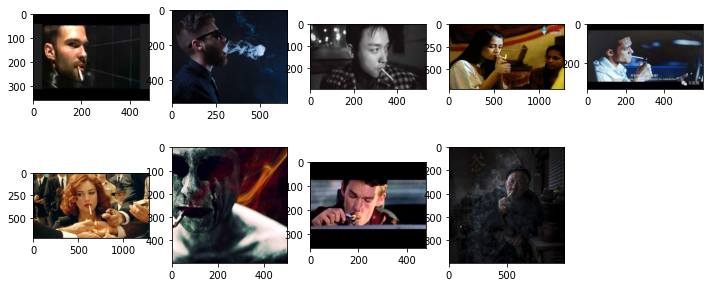

In [14]:
fig = plt.figure(figsize=(12,5)) #penentuan panjang dan lebar figure plot
kolom = 5 #nentuan kolom dalam melakukan plotting
baris = 2 #penentuan baris dalam melakukan plotting
for i in range (9): #melihat 9 foto terakhir dari dataset array -50
    fig.add_subplot(baris,kolom,i+1)
    plt.imshow(plt.imread(smoking[i]))

Dapat dilihat, gambar-gambar dair folder Smoking sangat bervariasi pengambilan gambarnya. Ada yang di ambil dari film dan di foto secara manual dan ada juga yang di ambil secara professional

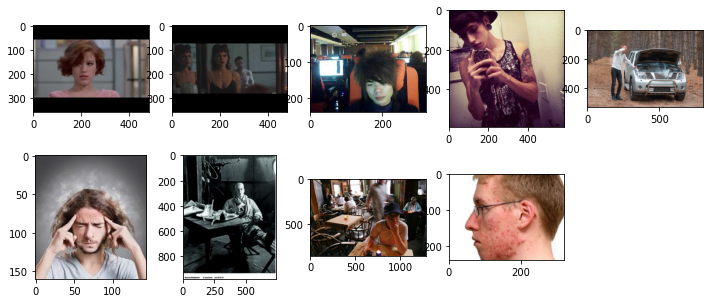

In [15]:
fig = plt.figure(figsize=(12,5)) #penentuan panjang dan lebar figure plot
kolom = 5 #nentuan kolom dalam melakukan plotting
baris = 2 #penentuan baris dalam melakukan plotting
for i in range (9): #melihat 9 foto terakhir dari dataset array -50
    fig.add_subplot(baris,kolom,i+1)
    plt.imshow(plt.imread(not_smoking[i]))

Untuk di bagian non smoking, foto nya juga sangat beragam dan menurut saya terlalu luas kemungkinannya untuk melakukan klasifikasi non smoking

## 5. Data Preprocessing

Di tahap ini, saya akan melakukan data preprocessing terhadap gambar dari kedua kelas tersebut dengan cara melakukan resizing, dan pembagian antara training & validation dataset

In [16]:
IMG_WIDTH=224
IMG_HEIGHT=224
batch_size=10

In [17]:
smoking_folder

'./data/smoking/'

In [18]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    shuffle=True,
    seed=42,
    subset = 'training',
    validation_split = 0.2,
    batch_size=batch_size,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
    )

Found 3275 files belonging to 2 classes.
Using 2620 files for training.


In [19]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    shuffle=True,
    seed=42,
    subset = 'validation',
    validation_split = 0.2,
    batch_size=batch_size,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
    )

Found 3275 files belonging to 2 classes.
Using 655 files for validation.


In [20]:
class_names = train_dataset.class_names
print(class_names)

['not_smoking', 'smoking']


#### Normalisasi data menggunakan layer tensorflow

Dalam tahap ini, saya akan membuat layer untuk normalisasi kepada setiap gambar yang dilakukan ketika memasuki neural network yang akan digunakan. Dengan membuat value terkecil di 0 dan tertinggi di 1

In [21]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [22]:
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## 6.Pendefinisian,Training, dan Evaluasi Model

Dalam pendefinisian model ini, saya akan menggunakan Sequential API dari keras untuk pembuatan neural network. Saya menggunakan CNN untuk melakukan filtering terhadap gambar tersebut.

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

In [24]:
num_classes = 2 #buat argumen output layer

model = Sequential([    
    layers.InputLayer(input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)),
    normalization_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

Dalam melakukan compiling model, saya menggunakan optimizer Adam, dengan loss BinaryCrossEntropy dikarenakan dataset yang saya gunakan merupakan binary class.

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

Saya juga akan membuat variabel baru untuk menampung nilai callback early stopping. Agar ketika model sudah di anggap konvergen, akan langsung di stop training model nya

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [27]:
epochs=15
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/15
262/262 [==============================] - 42s 123ms/step - loss: 5.9555 - accuracy: 0.6092 - val_loss: 5.9134 - val_accuracy: 0.6122
Epoch 2/15
262/262 [==============================] - 49s 183ms/step - loss: 5.9658 - accuracy: 0.6088 - val_loss: 5.9134 - val_accuracy: 0.6122
Epoch 3/15
262/262 [==============================] - 24s 89ms/step - loss: 5.9658 - accuracy: 0.6088 - val_loss: 5.9134 - val_accuracy: 0.6122
Epoch 4/15
262/262 [==============================] - 21s 79ms/step - loss: 5.9658 - accuracy: 0.6088 - val_loss: 5.9134 - val_accuracy: 0.6122


In [28]:
len(history.history['loss'])

4

Ketika sudah melakukan 4 epoch, model berhenti training lagi dikarenakan model loss dan accuracy serta validation accuracy sudah tidak ada improvement lagi

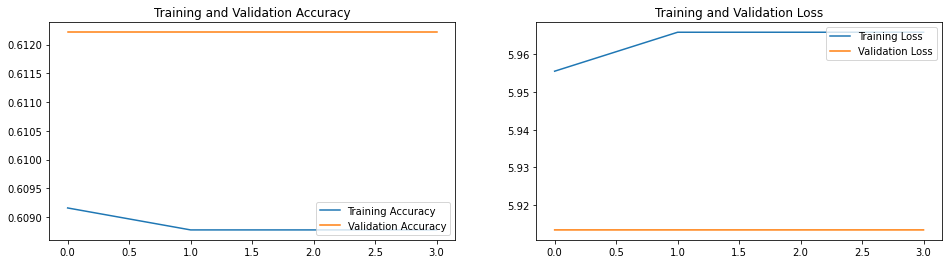

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Dapat dilihat, model awal saya memiliki training dan validation accuracy yang sangat rendah. Kemudian saya akan mencoba untuk melakukan model improvement kepada model baru dengan menggunakan dropout dan data augmentation

### Data Augmentation & Dropout layers

Melakukan data augmentasi agar model dapat belajar lebih baik ketika diberikan sedikit perubahan terhadap foto. Termasuk flip, rotasi, dan zoom. Dan untuk output layer, saya menggunakan activation function 'Sigmoid' dikarenakan dataset yang saya gunakan merupakan binary class

In [30]:
data_augmentation =tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.experimental.preprocessing.RandomRotation(0.125),
    layers.experimental.preprocessing.RandomZoom(0.125),
  ]
)

In [31]:
model = Sequential([
    normalization_layer,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1,activation='sigmoid')
])

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [33]:
epochs = 15
history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
    callbacks=[callback]
)

Epoch 1/15
262/262 [==============================] - 24s 85ms/step - loss: 0.6279 - accuracy: 0.6592 - val_loss: 0.6143 - val_accuracy: 0.6519
Epoch 2/15
262/262 [==============================] - 24s 88ms/step - loss: 0.5616 - accuracy: 0.7099 - val_loss: 0.5532 - val_accuracy: 0.7053
Epoch 3/15
262/262 [==============================] - 22s 84ms/step - loss: 0.5442 - accuracy: 0.7332 - val_loss: 0.5553 - val_accuracy: 0.7176
Epoch 4/15
262/262 [==============================] - 24s 91ms/step - loss: 0.5372 - accuracy: 0.7427 - val_loss: 0.5677 - val_accuracy: 0.7038
Epoch 5/15
262/262 [==============================] - 24s 90ms/step - loss: 0.5321 - accuracy: 0.7363 - val_loss: 0.5935 - val_accuracy: 0.7099
Epoch 6/15
262/262 [==============================] - 25s 92ms/step - loss: 0.5279 - accuracy: 0.7508 - val_loss: 0.5729 - val_accuracy: 0.7176
Epoch 7/15
262/262 [==============================] - 25s 92ms/step - loss: 0.5140 - accuracy: 0.7496 - val_loss: 0.5789 - val_accuracy:

lalu untuk improvement selanjutnya saya akan mencoba apabila tidak menggunakan dropout tetapi tetap menggunakan layer augmentasi kepada model selanjutnya.

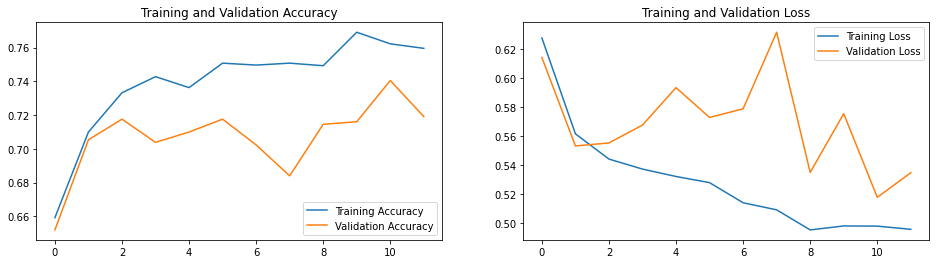

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
cnn=tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(filters=32,kernel_size=3,
padding='same',activation='relu',input_shape=[224,224,3]),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,
    padding='same',activation='relu'), 
    tf.keras.layers.MaxPool2D(pool_size=2), 
    tf.keras.layers.Conv2D(filters=256,kernel_size=3,
    padding='same',activation='relu'),  
    tf.keras.layers.MaxPool2D(pool_size=2),  
    tf.keras.layers.Flatten(),   
    tf.keras.layers.Dense(units=128,activation='relu'),    
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

In [36]:
cnn.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [37]:
epochs = 15
history = cnn.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=epochs,
    callbacks=[callback]
)

Epoch 1/15
262/262 [==============================] - 41s 143ms/step - loss: 13.4333 - accuracy: 0.6317 - val_loss: 0.7617 - val_accuracy: 0.6427
Epoch 2/15
262/262 [==============================] - 38s 142ms/step - loss: 0.6412 - accuracy: 0.6527 - val_loss: 0.7679 - val_accuracy: 0.6168
Epoch 3/15
262/262 [==============================] - 38s 145ms/step - loss: 0.6138 - accuracy: 0.6840 - val_loss: 0.6291 - val_accuracy: 0.6595
Epoch 4/15
262/262 [==============================] - 60s 228ms/step - loss: 0.6108 - accuracy: 0.6809 - val_loss: 0.6581 - val_accuracy: 0.6794
Epoch 5/15
262/262 [==============================] - 47s 179ms/step - loss: 0.6145 - accuracy: 0.6870 - val_loss: 0.7197 - val_accuracy: 0.6504
Epoch 6/15
262/262 [==============================] - 62s 235ms/step - loss: 0.5975 - accuracy: 0.6927 - val_loss: 0.7578 - val_accuracy: 0.6687
Epoch 7/15
262/262 [==============================] - 46s 175ms/step - loss: 0.5947 - accuracy: 0.6851 - val_loss: 0.8521 - val_a

Akurasi yang didapatkan dari model terakhir saya malah menurun. Maka dapat di simpulkan bahwa model ini tidak bagus, tetapi mungkin dapat di tanggulangi dengan melakukan penambahan image dalam dataset, dan memberi image data training yang lebih stabil dan jelas.

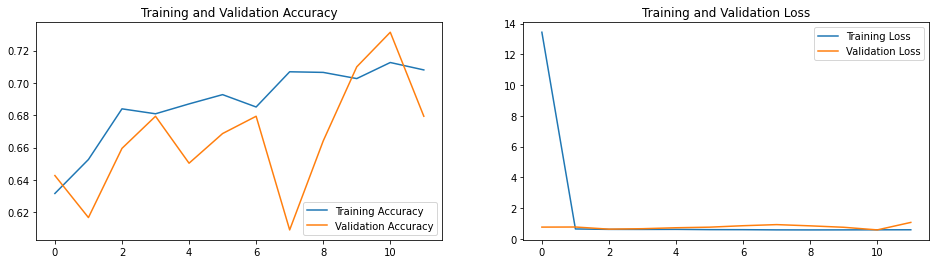

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Dapat dilihat, model yang saya gunakan di atas overfit dengan adanya perbedaan di bagian akurasi dari training dan validation data. Maka, saya akan mencoba untuk menggunakan pretrained model VGG16 dalam pengerjaan ini dengan metode transfer learning dari dataset ImageNet dan menggunakan Functional API. Saya akan menggunakan metode feature extraction terhadap pretrained model saya

In [39]:
from tensorflow.keras.applications import VGG16
vgg16=VGG16(weights="imagenet",include_top=False,
input_tensor=data_augmentation
for layer in vgg16.layers: #melakukan frozing layer terhadap semua layer dari vgg16
    layer.trainable = False
out = vgg16.output
out = layers.AveragePooling2D(pool_size=(7, 7))(out)
out = layers.Flatten(name="flatten")(out)
out = layers.Dense(128, activation="relu")(out)
out = layers.Dropout(0.5)(out)
out = layers.Dense(1, activation="sigmoid")(out)
model = tf.keras.Model(inputs=input_tensor, outputs=out)

In [40]:
for layer in vgg16.layers:
    layer.trainable = False
opt = tf.keras.optimizers.Adam(lr=0.0001, decay=0.0001 / 15)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

history = model.fit(
  train_dataset,
  validation_data=val_dataset,
  epochs=5,
    callbacks=[callback]
)

C:\Users\Dandy Alfikri\Documents\Hacktiv8_DS\Fase_2\Week 3\Milestone2\Milestone2\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
262/262 [==============================] - 151s 530ms/step - loss: 1.9496 - accuracy: 0.6256 - val_loss: 0.8448 - val_accuracy: 0.7145
Epoch 2/5
262/262 [==============================] - 127s 483ms/step - loss: 1.1948 - accuracy: 0.6916 - val_loss: 0.6803 - val_accuracy: 0.7679
Epoch 3/5
262/262 [==============================] - 124s 471ms/step - loss: 0.7658 - accuracy: 0.7496 - val_loss: 0.5711 - val_accuracy: 0.7786
Epoch 4/5
262/262 [==============================] - 129s 493ms/step - loss: 0.6540 - accuracy: 0.7653 - val_loss: 0.5273 - val_accuracy: 0.7817
Epoch 5/5
262/262 [==============================] - 127s 484ms/step - loss: 0.5665 - accuracy: 0.7748 - val_loss: 0.4970 - val_accuracy: 0.8031


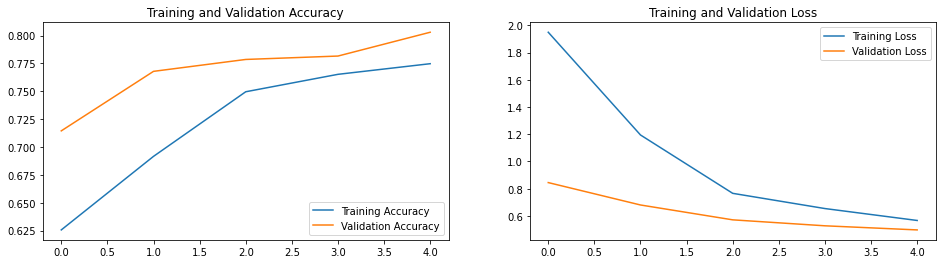

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Dari hasil di atas, dapat dilihat bahwa akurasi dari training data meningkat secara drastis dibandingkan tidak menggunakan pretrained model. Dikarenakan pretrained model sudah neuron-neuron yang sudah terlatih dari dataset yang sangat besar (ImageNet)

### Model Inference (menggunakan CNN w/o pretrained)

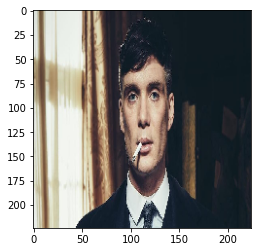

In [74]:
test_image = r'test_data/022bd71fc82b109c77ac3f42dce954e2-1564052342.jpg'

img = tf.keras.preprocessing.image.load_img(
    test_image, target_size=(224,224)
)
plt.imshow(img)

In [75]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = cnn.predict(img_array)


print(predictions[0])


[0.6503191]


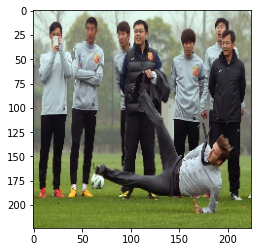

In [72]:
test_image = r'test_data/5297058_20130324115915.jpg'

img = tf.keras.preprocessing.image.load_img(
    test_image, target_size=(224,224)
)
plt.imshow(img)

In [73]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = cnn.predict(img_array)

print(predictions)
if(predictions<0.5):
    print('Gambar tersebut diklasifikasi kan sebagai not smoking')
else:
    print('Gambar tersebut diklasifikan sebagai smoking')

[[0.4253522]]


Dapat dilihat, jika menggunakan CNN model tanpa pretrrained model dapat melakukan model inference dengan baik dari kedua gambar diatas

## Menggunakan Pretrained model VGG16

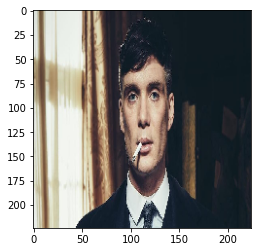

In [76]:
test_image = r'test_data/022bd71fc82b109c77ac3f42dce954e2-1564052342.jpg'

img = tf.keras.preprocessing.image.load_img(
    test_image, target_size=(224,224)
)
plt.imshow(img)

In [77]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(predictions[0])
if(predictions<0.5):
    print('Gambar tersebut diklasifikasi kan sebagai not smoking')
else:
    print('Gambar tersebut diklasifikan sebagai smoking')

[0.85910475]
Gambar tersebut diklasifikan sebagai smoking


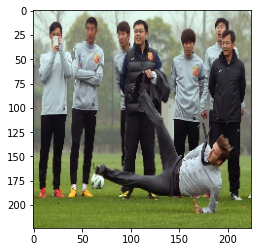

In [85]:
test_image = r'test_data/5297058_20130324115915.jpg'

img = tf.keras.preprocessing.image.load_img(
    test_image, target_size=(224,224)
)
plt.imshow(img)

In [86]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(predictions)
if(predictions<0.5):
    print('Gambar tersebut diklasifikasi kan sebagai not smoking')
else:
    print('Gambar tersebut diklasifikan sebagai smoking')

[[0.23549254]]
Gambar tersebut diklasifikasi kan sebagai not smoking


Keduanya bekerja cukup baik dalam mengklasifikasikan gambar antara smoking dan non smoking

### Overall Analysis
Dari analisa saya terhadap beberapa model yang sudah saya buat dan improve mengenai kasus ini adalah dikarenakan dataset yang kurang begitu bagus dan distinguish di bagian smoking dan non smoking maka hasil nya tidak dapat memberikan akurasi yang optimal. Tetapi, pretrained model VGG16 memiliki nilai akurasi yang cukup tinggi untuk kasus ini. Maka dari itu, saya akan melakukan saving model dari VGG16 untuk deployment

### Saving Model

In [80]:
model_version = "0003"
model_name = "my_smoking_model"
model_path = os.path.join(model_name, model_version)
model_path

'my_smoking_model\\0003'

In [81]:
tf.keras.models.save_model(model, model_path)

INFO:tensorflow:Assets written to: my_smoking_model\0003\assets


In [82]:
imported = tf.keras.models.load_model(model_path)

In [87]:
imported.predict(img_array)

array([[0.23549254]], dtype=float32)